In [17]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt

import pyrr
import itertools

#basedir = os.path.dirname("/mnt/sda/Github/LiDAR/")
basedir = os.path.abspath(os.path.join(os.getcwd() ,"../"))
_py = os.path.join(basedir, 'py')
_data = os.path.join(basedir, 'data')
print(basedir)
print(_py)
sys.path.insert(1, _py)
print(sys.path)
import loads 
import lia
import ray as rayt
import lad
import figures

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2


/mnt/sda/Github/LiDAR
/mnt/sda/Github/LiDAR/py
['/mnt/sda/Github/LiDAR/nb', '/mnt/sda/Github/LiDAR/py', '/mnt/sda/Github/LiDAR/py', '/mnt/sda/Github/LiDAR/py', '/home/jzhu/miniconda3/envs/plant-env/lib/python38.zip', '/home/jzhu/miniconda3/envs/plant-env/lib/python3.8', '/home/jzhu/miniconda3/envs/plant-env/lib/python3.8/lib-dynload', '', '/home/jzhu/.local/lib/python3.8/site-packages', '/home/jzhu/miniconda3/envs/plant-env/lib/python3.8/site-packages']
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import loads


loads.csv2npy(mockname="groimp_mock")

GroIMP_PointClouds.csv done --> Number of beams: 118018


In [4]:
from plyfile import PlyData, PlyElement
datapath = os.path.join(_data,"groimp_mock")
file = os.path.join(datapath, 'skiwicanopy.ply')

df1 = PlyData.read(file)
df = np.transpose([df1.elements[0].data['x'],
                    df1.elements[0].data['y'],
                    df1.elements[0].data['z']])
print(df)

[[-16.39697  -8.52318   1.79079]
 [-16.3551   -8.61365   1.79874]
 [-16.30622  -8.48118   1.79079]
 [-16.26435  -8.57164   1.79874]
 [-16.4947   -8.14769   1.71079]
 [-16.4578   -8.15008   1.80371]
 [-16.48826  -8.0479    1.71079]
 [-16.45136  -8.05028   1.80371]
 [-16.65464  -7.7528    1.83679]
 [-16.73903  -7.79221   1.87318]
 [-16.61232  -7.8434    1.83679]
 [-16.69672  -7.88282   1.87318]
 [-17.01766  -8.32375   1.66179]
 [-16.94083  -8.38693   1.67211]
 [-16.95414  -8.24652   1.66179]
 [-16.87731  -8.3097    1.67211]
 [-16.79543  -8.30323   1.77179]
 [-16.87608  -8.24835   1.79378]
 [-16.85168  -8.3859    1.77179]
 [-16.93234  -8.33102   1.79378]
 [-16.91643  -8.168     1.69479]
 [-16.96889  -8.17926   1.77918]
 [-16.89545  -8.26577   1.69479]
 [-16.94791  -8.27703   1.77918]
 [-17.12974  -7.70966   1.75979]
 [-17.08376  -7.74013   1.8432 ]
 [-17.0745   -7.6263    1.75979]
 [-17.02852  -7.65678   1.8432 ]
 [-16.47372  -8.17275   1.88679]
 [-16.47536  -8.24326   1.95769]
 [-16.3737

In [5]:
from numpy import genfromtxt
datapath = os.path.join(_data,"groimp_mock")
file = os.path.join(datapath, 'GroIMP_PointClouds.csv')
#df = np.genfromtxt(file, delimiter=',', encoding=None, names=True,
#    dtype= float)
df = np.loadtxt(file, delimiter=',', 
                dtype={'names':('x', 'y', 'z'),
                'formats':('f4', 'f4', 'f4')})
print(df)
print(file)

#np.genfromtxt(txt, delimiter=',', names=True, dtype=None, encoding=None)



[(-16.1242, -7.9692, 1.8476) (-16.1167, -8.0632, 1.777 )
 (-16.121 , -8.4483, 1.8179) ... (-16.6715, -8.3109, 1.9594)
 (-17.0324, -8.494 , 1.8505) (-17.1047, -7.739 , 2.0039)]
/mnt/sda/Github/LiDAR/data/groimp_mock/GroIMP_PointClouds.csv


If `downsample` is not None, a random downsampling will be implemented. If None, the pipeline will use the voxel-based downsampling.

In [6]:
mockname = 'groimp_mock'
voxel_size = 0.05
downsample = None

In [7]:
mockname

'groimp_mock'

## Tree and leaves segmentation

Now we create the module to segmentate trees. This will be tuned acordingly for each data set, so below module only works for this particular data set.

In [8]:
def segtree(df, leaves, show=False):

    trees = {}

    if show:
        plt.figure(figsize=(14, 8))

    # centres
    x, y = [-16.6], [-8.16]
    num = 0
    dx, dy = 20, 10
    # dx, dy = 5, 5

    for i in x:
        for j in y:
            
            keep = np.ones(len(df['x']), dtype=bool)
            #keep &= (df['x'] < i+dx) & (df['x'] > i-dx)
            #keep &= (df['y'] < j+dy) & (df['y'] > j-dy)

            trees['tree_%s' %(str(num))] = keep
            
            if show:
                plt.scatter(df['x'][leaves & keep], df['y'][leaves & keep], s=0.5, label=num)
                        
            num += 1

    if show:
        plt.legend()
    
    return trees


We segmentate the trees below,

In [9]:
# load data into a pandas data frame
df = loads.plynpy2pandas(mockname)
N = len(df)

#print(df['z'])
df

Number of files: 2


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

In [10]:

def voxel_subsampling(voxel_size, POINTS):

    nb_vox = np.ceil((np.max(POINTS, axis=0) - np.min(POINTS, axis=0))/voxel_size)
    ni, nj, nk = nb_vox
    print('min point:', np.min(POINTS, axis=0))
    print('max point:', np.max(POINTS, axis=0))
    print('Number of voxels: i:%d, j:%d, k:%d --> Total: %d' %(ni, nj, nk, np.product(nb_vox)))

    non_empty_voxel_keys, inverse, nb_pts_per_voxel = np.unique(((POINTS - np.min(POINTS, axis=0)) // voxel_size).astype(int), axis=0, return_inverse=True, return_counts=True)
    idx_pts_vox_sorted = np.argsort(inverse)
    print('Number of non-empty voxels: %d' %(len(non_empty_voxel_keys)))

    voxel_grid={}
    voxel_grid_ptsidx = {}
    grid_barycenter,grid_candidate_center = [], []
    last_seen=0

    for idx, vox in enumerate(non_empty_voxel_keys):

        idxs_per_vox = idx_pts_vox_sorted[last_seen:last_seen+nb_pts_per_voxel[idx]]
        voxel_grid[tuple(vox)] = POINTS[idxs_per_vox]
        voxel_grid_ptsidx[tuple(vox)] = idxs_per_vox

        # grid_barycenter.append(np.mean(voxel_grid[tuple(vox)],axis=0))

        idx_grid_candidate_center = np.linalg.norm(voxel_grid[tuple(vox)] - np.mean(voxel_grid[tuple(vox)],axis=0),axis=1).argmin()
        grid_candidate_center.append(voxel_grid_ptsidx[tuple(vox)][idx_grid_candidate_center])

        last_seen+=nb_pts_per_voxel[idx]

    # print('Downsampling percentage: %.1f %%' %(100 * len(grid_candidate_center) / len(POINTS)))
    # minpoint = np.min(POINTS, axis=0)

    return list(grid_candidate_center) #, minpoint

In [14]:
def random_downsample(N, downsample):

    resdir = os.path.join(_data, mockname, 'random_%s' %(str(downsample)))
    if not os.path.exists(resdir):
        os.makedirs(resdir)

    outdir = os.path.join(resdir, 'inds.npy')
    if os.path.exists(outdir):
        print('inds file already exists for donwnsample of %.3f at %s' %(downsample, outdir))

        idx = np.load(outdir)

    else:

        print('inds not been created yet for donwnsample of %.3f' %(downsample))
        idx = np.random.randint(0, N, int(N * downsample))
        # inds = np.zeros(N, dtype=bool)
        # inds[idx] = True

        np.save(outdir, idx)

    return idx

### Implement and keep Downsamplied points

In [15]:

if downsample is not None:
    inds = random_downsample(N, downsample)
else:
    inds = voxel_subsampling(voxel_size, df[['x', 'y', 'z']].to_numpy())

print('Downsampling percentage: %.1f %%' %(100 *  len(inds) / len(df['x'])))

df = df.iloc[inds]
POINTS = df[['x', 'y', 'z']].to_numpy()
SENSORS = df[['sx', 'sy', 'sz']].to_numpy()

# Compute lower point
minpoint = np.min(POINTS, axis=0)
print('minpoint:', minpoint)



AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

### leave and tree segmentation

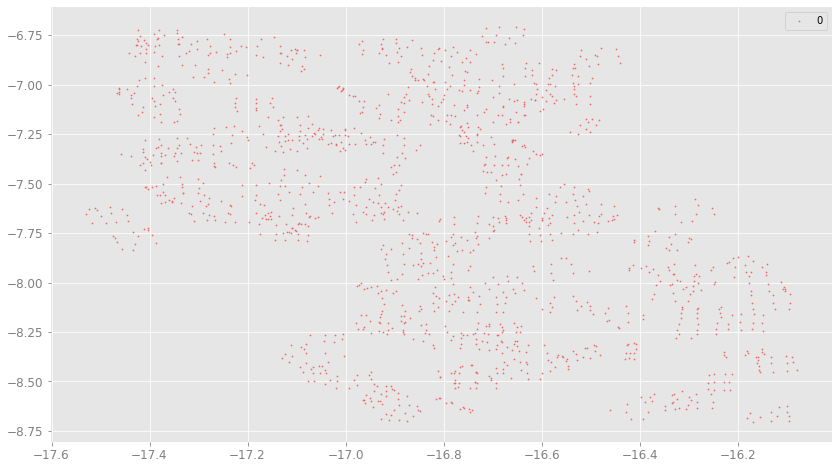

In [128]:
# extract leaves. Boolean array output
leaves = loads.extract_leaves_2(df, show=False)

# extract trees. Dictionary with boolean arrays output
trees = segtree(df, leaves, show=True)


### Second downsampling: keep only points that colide with Plant Region

In [1]:
inPR = (leaves) & (trees['tree_0'])
minBB, maxBB = np.min(POINTS[inPR], axis=0), np.max(POINTS[inPR], axis=0)
print(minBB, maxBB)

NameError: name 'leaves' is not defined

In [130]:
minBB, maxBB = np.min(POINTS[inPR], axis=0), np.max(POINTS[inPR], axis=0)

# Make sure Plant Region min & max points are multiples of voxel size
# to match first voxelization where we implemented the downsampling
minpointPR = minpoint + np.floor(np.abs(minpoint - minBB)/voxel_size) * voxel_size
maxpointPR = minpoint + np.ceil(np.abs(minpoint - maxBB)/voxel_size) * voxel_size
boxPR = pyrr.aabb.create_from_bounds(minpointPR, maxpointPR)

lines = np.stack((POINTS, SENSORS), axis=1)
f = lambda line: pyrr.geometric_tests.ray_intersect_aabb(pyrr.ray.create_from_line(line), boxPR) is not None
res = np.array(list(map(f, lines)))

In [131]:
POINTS, SENSORS = POINTS[res], SENSORS[res]

leaves = leaves[res]

for key, val in trees.items():
    trees[key] = val[res]

In [132]:
# save indexes of voxel-based downsample

idxs = np.array(inds)[res]

if downsample is not None:
    dirname = 'random_%s' %(str(downsample))
    resdir = os.path.join(_data, mockname, dirname, 'lad_%s' %(str(voxel_size)))
else:
    dirname = 'voxel'
    resdir = os.path.join(_data, mockname, dirname, 'lad_%s' %(str(voxel_size)))

if not os.path.exists(resdir): os.makedirs(resdir)
outdir = os.path.join(resdir, 'inds.npy')
np.save(outdir, idxs)

## Ray tracing

In [133]:
sample = None

inPR = (leaves) & (trees['tree_0'])

# resdir = os.path.join(_data, mockname, 'lad_%s' %(str(voxel_size)))
# if not os.path.exists(resdir):
    # os.makedirs(resdir)
if sample is not None:
    print('# iter...', len(POINTS[::sample]))
    m3s = rayt.main2(POINTS[::sample], SENSORS[::sample], POINTS[inPR], voxel_size, resdir, 'tree_0', (minpointPR, maxpointPR), show=True)
else:
    print('# iter...', len(POINTS))
    m3s = rayt.main2(POINTS, SENSORS, POINTS[inPR], voxel_size, resdir, 'tree_0', (minpointPR, maxpointPR), show=False)

# iter... 1483


1483it [00:18, 82.24it/s] 

tot vox: 	 15080
voxels hitted: 	 3274
Percentage of voxels hitted by beam: 0.22
voxels hitted (OLD): 	 0
Percentage of voxels hitted by beam (OLD): 0.00


In [134]:
POINTS[inPR]

array([[-17.518 ,  -7.6975,   1.6993],
       [-17.5081,  -7.6319,   1.6948],
       [-17.529 ,  -7.6526,   1.6978],
       ...,
       [-16.1029,  -8.0411,   1.8439],
       [-16.1031,  -8.0318,   1.8487],
       [-16.1057,  -8.0224,   1.8489]], dtype=float32)

## LIA

In [138]:
def best_fit_lia(mockname, Nleaves):

    df = loads.plynpy2pandas(mockname)
    # extract leaves. Boolean array output
    
    # leaves = loads.extract_leaves(df, show=False)
    leaves = np.ones(len(df), dtype=bool)
    for i in ['x', 'y']:
        leaves &= (df[i] > -1) & (df[i] < 1)

    # extract trees. Dictionary with boolean arrays output
    trees = segtree(df, leaves, show=False)

    for key, val in trees.items():

        keep = (val) & (leaves) # take the LPC per tree
        points = df[['x', 'y', 'z']].to_numpy()[keep]

        res = lia.bestfit_pars_la(points, mockname, Nleaves, treename=key)
        lia.best_fit_pars_plot(res, key, mockname)

In [143]:
def get_lia(mockname):

    df = loads.plynpy2pandas(mockname)

    # extract leaves. Boolean array output

    # leaves = loads.extract_leaves(df, show=False)
    leaves = np.ones(len(df), dtype=bool)
   # for i in ['x', 'y']:
    #    leaves &= (df[i] > -1) & (df[i] < 1)

    # extract trees. Dictionary with boolean arrays output
    trees = segtree(df, leaves, show=False)


    # load bestfit results
    for key, val in trees.items():

        keep = (val) & (leaves)
        print(sum(keep), len(keep))
        points = df[['x', 'y', 'z']].to_numpy()[keep]
    
        #bestfit_file = os.path.join(_data, mockname, 'lia', 'bestfit_%s.npy' %(key))
        #res = np.load(bestfit_file, allow_pickle=True)
        #res = res.tolist()

        #text = 'leaf area=%.2f \n %s=%.4f \n %s=%.4f \n %s=%.4f ' %(res['leafsize'], 'voxel_size_w', res['voxel_size_w_bestfit'],'kd3_sr', res['kd3_sr_bestfit'],'max_nn', res['max_nn_bestfit'])
        # print(text)

        chi2 = lia.leaf_angle(points, mockname, key, 0.1, 0.01, 10, save=True, 
                              text="leaf2", savefig=True, voxel_size_h=0.1, ismock=False)

        # save indexes from main df
        # inds = np.where((val) & (leaves))
        np.save(os.path.join(_data, mockname, 'lia', 'inds.npy'), keep)


In [142]:

#best_fit_lia(mockname, Nleaves=2)

Number of files: 1
118018 118018


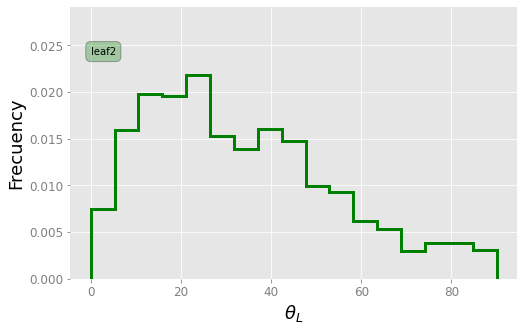

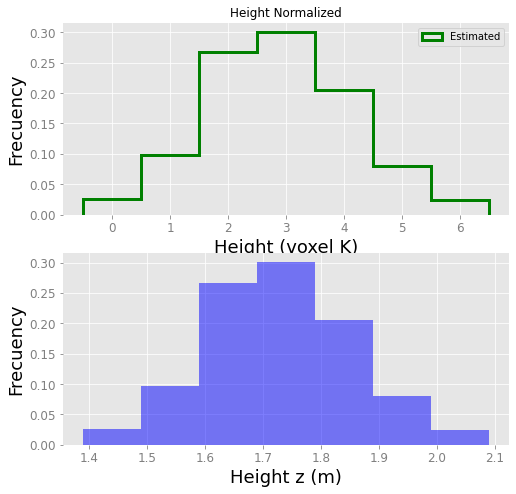

In [144]:
get_lia(mockname)

In [145]:
inds_file = os.path.join(resdir, 'inds.npy')
inds = np.load(inds_file)
print(inds)

[ 38958  57711  30160 ... 101970  93817  91286]


In [146]:
inds_lia = np.load(os.path.join(_data, mockname, 'lia', 'inds.npy'))
print(inds_lia)

[ True  True  True ...  True  True  True]


In [154]:
PRbounds

NameError: name 'PRbounds' is not defined

In [168]:
def runall(pointsPR, sensorsPR, inPR, voxel_size, tree, N, PRbounds, resdir, kbins=None):

    # resdir = os.path.join(_data, mockname, 'lad_%s' %(str(voxel_size)))
    inds_file = os.path.join(resdir, 'inds.npy')
    inds0 = np.load(inds_file)

    # resdir = os.path.join(_data, mockname, 'lad_%s' %(str(voxel_size)))

    inds_lia = np.load(os.path.join(_data, mockname, 'lia', 'inds.npy'))

    isfigures = os.path.join(resdir, 'figures')
    if not os.path.exists(isfigures):
        os.makedirs(isfigures)

    attributes2_file = os.path.join(resdir, 'm3s_%s_%s.npy' %(tree, str(voxel_size)))
    if os.path.isfile(attributes2_file):
        m3b = np.load(attributes2_file)

    print('voxel_size:', voxel_size)

    # m3att = lad.compute_attributes(pointsPR, resdir, voxel_size, tree, PRbounds)

    # _,_,_, m3scount = lad.density_counts(pointsPR, voxel_size)

    # Load LIAs and its weights saved at `get_lia()`.
    # Size of lias and ws arrays is the original size after leaf and tree extraction only.
    lias, ws = loads.load_lias_ws(mockname, 'tree_0')

    # Create  arrays of original size filled with -99
    lias0 = np.full(N, -99)
    ws0 = np.full(N, -99)

    # fill arrays with lias and ws values where it correspond to.
    lias0[np.where(inds_lia)[0]] = lias
    ws0[np.where(inds_lia)[0]] = ws

    # Finally, apply downsampling and second dowsampling to lias and ws.
    lias = lias0[inds0[inPR]]
    ws = ws0[inds0[inPR]]

    try:
        assert len(lias) == sum(inPR)
    except Exception as e:lads = {'Truth':lads_mesh, 'Correction Mean C=1':lads_mid_1, 'No Correction C=1':lads_0}
    voxk = lad.get_voxk(pointsPR, PRbounds, voxel_size)
    bia = lad.get_bia(pointsPR, sensorsPR)
    #meshfile = lad.get_meshfile(mockname)
    meshfile = None
    # print('----- DEBUG -----')
    # print(len(lias), len(ws), len(voxk))

    figext = '%s_%s' %(tree, str(voxel_size))
    # figext = None
    
    alphas_k = lad.alpha_k(bia, voxk, lias, ws, resdir, meshfile, figext=figext, 
                            klia=False, use_true_lia=False)

    kmax = m3b.shape[2]
    
    if kbins is None:
        kbins = int(kmax/15)
    print('kmax', kmax)
    print('kbins', kbins)

    # Attribute 2 counts per voxel
    # outdir_count = os.path.join(resdir, 'm3count_%s_%s.npy' %(tree, str(voxel_size)))

    oldlad = True
    
    lads_mid_1, clai_1 = lad.get_LADS2(pointsPR, kmax, voxel_size, kbins, alphas_k[:,6], PRbounds, tree, resdir, oldlad=oldlad, C=1)
    # lads_mid_05, clai_05 = lad.get_LADS2(pointsPR, kmax, voxel_size, kbins, alphas_k[:,6], PRbounds, tree, resdir, oldlad=True, C=0.5)
    lads_0, clai_0 = lad.get_LADS2(pointsPR, kmax, voxel_size, kbins, alphas_k[:,6]*0+1, PRbounds, tree, resdir, oldlad=oldlad, C=1)

    # lads_mid_old, _ = lad.get_LADS2(pointsPR, kmax, voxel_size, kbins, alphas_k[:,6], PRbounds, tree, resdir, oldlad=True)
    # lads_mid_old = lad.get_LADS(m3att, voxel_size, kbins, alphas_k[:,6], alpha2=1)
    #lads_mesh = lad.get_LADS_mesh(meshfile, voxel_size, kbins, kmax, PRbounds, inverted=True)

    # lads = {'Truth':lads_mesh, 'Correction Mean':lads_mid, 'No Correction':lads_0, 'Correction Weights':lads_mid_w}#, 'Correction counts':lads_mid_counts}
    # lads = {'Truth':lads_mesh, 'Correction Mean C=1':lads_mid_1, 'Correction Mean C=0.5':lads_mid_05,}
    #lads = {'Truth':lads_mesh, 'Correction Mean C=1':lads_mid_1, 'No Correction C=1':lads_0}
    lads = { 'Correction Mean C=1':lads_mid_1, 'No Correction C=1':lads_0}
    print(lads_mid_1)
    # clai = lad.get_clai(m3att, alphas_k)
    attributes_file = os.path.join(resdir, 'm3s_%s_%s.npy' %(tree, str(voxel_size)))
    if os.path.isfile(attributes_file):
        RT = 'Y'
    else:
        RT = 'N'
        
    # text = {'tree':tree, 'VS':voxel_size, 'RT':RT, 'CLAI 1.0':np.round(clai_1, 3),  'CLAI 0.5':np.round(clai_05, 3)}
    text = {'tree':tree, 'VS':voxel_size, 'RT':RT, 'CLAI 1.0':np.round(clai_1, 3),  'CLAI 1.0 -- NC':np.round(clai_0, 3)}
    txt = []
    for key, val in text.items():
        txt.append('%s=%s \n' %(key, str(val)))
    text = (' ').join(txt)

    savefig = os.path.join(resdir, 'figures','LAD_%s.png' %(figext))
    figures.plot_lads(lads, text, savefig=savefig)


Below issue is related to LIA, `voxk` size is the same as `POINTS[inPR]` of 33145. We have to build an array that has same dimmensions as `POINTS[inPR]` and asociated the LIA values to it.

In [169]:
len(POINTS[inPR])

1483

voxel_size: 0.05
kmax 13
kbins 2
/mnt/sda/Github/LiDAR/data/groimp_mock/voxel/lad_0.05/m3count_tree_0_0.05.npy
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 4 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 2 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
/mnt/sda/Github/LiDAR/data/groimp_mock/voxel/lad_0.05/m3count_tree_0_0.05.npy
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 

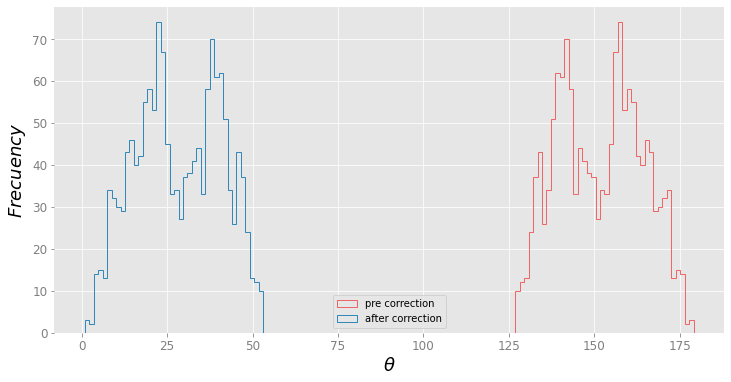

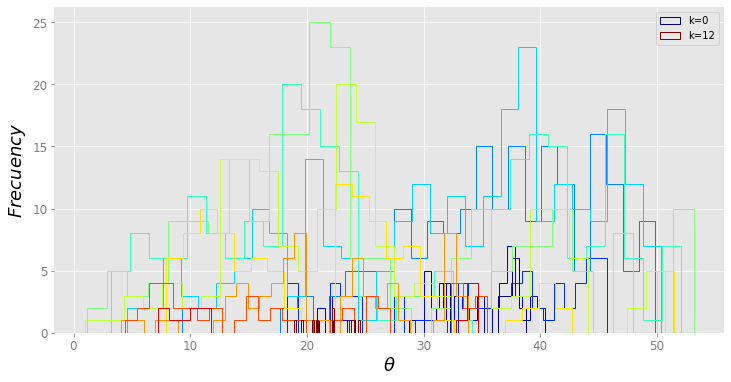

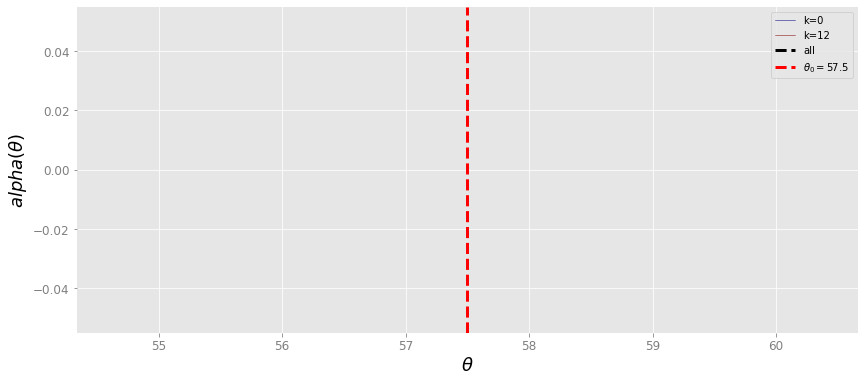

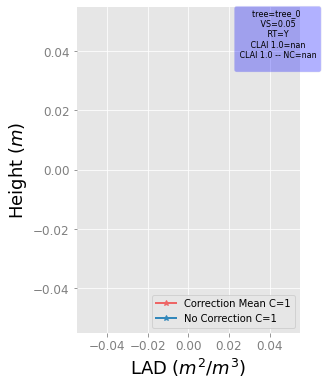

In [170]:
inPR = (leaves) & (trees['tree_0'])
runall(POINTS[inPR], SENSORS[inPR], inPR, voxel_size, 'tree_0', N, (minpointPR, maxpointPR), resdir, kbins=2)

In [3]:
# Check we have a mesh
if True:
    meshfile = os.path.join(_data, mockname, 'mesh.ply')
    lad.see_mesh(meshfile)

[Open3D WARNING] geometry::TriangleMesh appears to be a geometry::PointCloud (only contains vertices, but no triangles).
[Open3D WARNING] [SimpleShaderForTriangleMesh] Binding failed with empty triangle mesh.
[Open3D WARNING] [SimpleShaderForTriangleMesh] Binding failed when preparing data.
[Open3D WARNING] [SimpleShaderForTriangleMesh] Something is wrong in compiling or binding.
[Open3D WARNING] [SimpleBlackShaderForTriangleMeshWireFrame] Binding failed with empty geometry::TriangleMesh.
[Open3D WARNING] [SimpleBlackShaderForTriangleMeshWireFrame] Binding failed when preparing data.
[Open3D WARNING] [SimpleBlackShaderForTriangleMeshWireFrame] Something is wrong in compiling or binding.
[Open3D WARNING] [SimpleShaderForTriangleMesh] Binding failed with empty triangle mesh.
[Open3D WARNING] [SimpleShaderForTriangleMesh] Binding failed when preparing data.
[Open3D WARNING] [SimpleShaderForTriangleMesh] Something is wrong in compiling or binding.
[Open3D WARNING] [SimpleBlackShaderForTria

KeyboardInterrupt: 